# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison. We report performance as area under the precision recall curve (AUPR) and area under the receiver operating curve (AUROC). In both cases the greater the area the better the model is.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes

In [3]:
total_candidates_df = pd.read_csv("input/all_ctd_candidates.tsv.xz", sep="\t").sort_values("candidate_id")
total_candidates_df.head(2)

,doid_id,doid_name,drugbank_id,drug_name,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
2053869,DOID:1826,epilepsy syndrome,DB00313,Valproic Acid,1,9402,1,0.44093,9,65851,686471,The rectal route of administration was effecti...,21
796343,DOID:3571,liver cancer,DB00129,L-Ornithine,0,198,1,0.74806,10,65852,284568,The turnover rates of ornithine amino-transfer...,22


In [4]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [5]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_ctd")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [6]:
distant_supervision_marginals = pd.read_csv("input/baseline_sampled.tsv.xz", sep="\t")
distant_supervision_marginals.head(2)

,"0:0,1,2",candidate_id
0,0.999999,65851
1,0.182980,65856


In [7]:
all_embedded_cd_df = pd.read_csv("input/all_embedded_cd_sentences_fixed.tsv", sep="\t")
all_embedded_cd_df.head(2)

/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  """Entry point for launching an IPython kernel.


,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,candidate_id,sen_length
0,44,2,45,4,46,47,48,49,50.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65956,38
1,17,70,19,49,71,72,73,74,75.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65991,41


In [8]:
word_dict = pd.read_csv("input/compound_treats_disease_word_dict.tsv", sep="\t").assign(index=lambda x: x.index + 2)
word_dict.head()

,word,index
0,~~[[1,2
1,dexamethasone,3
2,1]]~~,4
3,also,5
4,stimulates,6


In [9]:
reverse_word_dict = dict(zip(word_dict['index'].values.tolist(), word_dict.word))

train_marginal_dict = dict(zip(
    distant_supervision_marginals.candidate_id, 
    distant_supervision_marginals[distant_supervision_marginals.columns[0]]
))

tune_marginal_dict = dict(zip(
    candidate_dfs['dev'].candidate_id.values,
    candidate_dfs['dev'].curated_ctd.values
))


test_marginal_dict = dict(zip(
    candidate_dfs['test'].candidate_id.values,
    candidate_dfs['test'].curated_ctd.values
))

In [11]:
data_rows = []
entity_one_start = word_dict.query("word=='~~[[1'")['index'].values[0]
entity_one_end = word_dict.query("word=='1]]~~'")['index'].values[0]

entity_two_start = word_dict.query("word=='~~[[2'")['index'].values[0]
entity_two_end = word_dict.query("word=='2]]~~'")['index'].values[0]


with open("output/optimization_data/training.txt", "w") as train:
    with open("output/optimization_data/tune.txt", "w") as tune:
        with open("output/optimization_data/test.txt", "w") as test:
            with open("output/all_cd_sentences.txt", "w") as all_sen:
                for idx, sen_df in tqdm_notebook(all_embedded_cd_df.iterrows()):
                    sen = sen_df.iloc[:-2].tolist()
                    try:
                        # remove entity mentions for coco_score
                        del sen[sen.index(entity_one_start): sen.index(entity_one_end)+1]
                        del sen[sen.index(entity_two_start): sen.index(entity_two_end)+1]

                        embedded_sen = list(map(
                            lambda x: reverse_word_dict[x] if x in reverse_word_dict else "UNK" if x == 1 else "",
                            sen
                        ))

                        cand_id = int(sen_df.iloc[-2])
                        if cand_id in train_marginal_dict:
                            train.write(
                                f"__label__{'1' if train_marginal_dict[cand_id]> 0.5 else '0'}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in tune_marginal_dict:
                            tune.write(
                                f"__label__{int(tune_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )
                        if cand_id in test_marginal_dict:
                            test.write(
                                f"__label__{int(test_marginal_dict[cand_id])}\t" +
                                "\t".join(embedded_sen)+ 
                                "\n"
                            )

                        all_sen.write(
                                f"__label__{cand_id}\t" +
                                "\t".join(embedded_sen) + 
                                "\n"
                            )

                    except ValueError:
                        print(idx)


/home/danich1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


1652505



In [12]:
os.system(
    "../../../../../fastText/fasttext supervised " + 
    "-input output/optimization_data/training.txt -output output/ctd_model " +
    "-lr 0.005 -epoch 50 -dim 300 -wordNgrams 2" 
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/ctd_model.bin output/optimization_data/tune.txt "+
    " > output/optimized_predictions/tune_predictions.tsv"
)

os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/ctd_model.bin output/optimization_data/test.txt "+
    " > output/optimized_predictions/test_predictions.tsv"
)

0

In [13]:
tune_df = (
    pd.read_csv(
        'output/optimized_predictions/tune_predictions.tsv', 
        header=None, sep=" ", 
        names=["label", "pred"]
    )
    .assign(label=lambda x: x.label.apply(lambda sen: sen[-1]))
)

precision, recall, _ = precision_recall_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(recall, precision)

0.46083814094631664

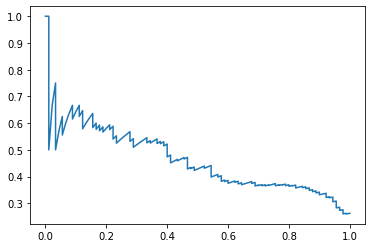

In [14]:
plt.plot(recall, precision)

In [15]:
fpr, tpr, _ = roc_curve(
    tune_df.label.astype(int).values,
    1-tune_df.pred.values
)
auc(fpr, tpr)

0.795344506517691

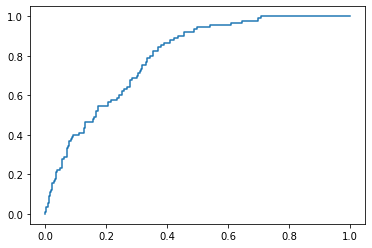

In [16]:
plt.plot(fpr, tpr)

In [17]:
os.system(
    "../../../../../fastText/fasttext predict-prob "+
    "output/ctd_model.bin output/all_cd_sentences.txt "+
    "> output/all_cd_sentences_predictions.tsv"
)

0

In [18]:
predictions_df = (
    pd.read_csv(
        "output/all_cd_sentences_predictions.tsv", 
        header=None, sep=" ",
        names=["label", "coco_pred"]
    )
    .assign(candidate_id=all_embedded_cd_df.drop(1652505).candidate_id.values.tolist())
    .assign(coco_pred=lambda x: 1 - x.coco_pred)
    .assign(coco_pred=lambda x: x.coco_pred.clip(0,1) + 1e-5)
)
predictions_df.head(2)

,label,coco_pred,candidate_id
0,__label__0,0.284164,65956
1,__label__0,0.109494,65991


In [19]:
final_pred_df = (
    total_candidates_df
    [["doid_id", "drugbank_id", "candidate_id"]]
    .merge(predictions_df[["coco_pred", "candidate_id"]])
)
final_pred_df.head(2)

,doid_id,drugbank_id,candidate_id,coco_pred
0,DOID:1826,DB00313,65851,0.140156
1,DOID:3571,DB00129,65852,0.003209


In [20]:
added_scores_df = (
    final_pred_df
    .groupby(["doid_id", "drugbank_id"])
    .aggregate({"coco_pred": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,doid_id,drugbank_id,coco_pred
0,DOID:0050156,DB00091,6.864369
1,DOID:0050156,DB00104,0.113919


In [21]:
total_score = added_scores_df.coco_pred.sum()
disease_scores = added_scores_df.groupby("doid_id").agg({"coco_pred":"sum"}).reset_index()
disease_scores = dict(zip(disease_scores.doid_id, disease_scores.coco_pred))
drug_scores = added_scores_df.groupby("drugbank_id").agg({"coco_pred":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.drugbank_id, drug_scores.coco_pred))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['coco_pred']) + (1-alpha)*(
                    pd.np.log(x['coco_pred']) + pd.np.log(total_score) - 
                    pd.np.log(disease_scores[x['doid_id']]) - pd.np.log(drug_scores[x['drugbank_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,doid_id,drugbank_id,coco_pred,final_score
0,DOID:0050156,DB00091,6.864369,5.415513
1,DOID:0050156,DB00104,0.113919,0.192935


In [22]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["drugbank_id", "doid_id", "hetionet"]],
        on=["drugbank_id", "doid_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,doid_id,drugbank_id,coco_pred,final_score,hetionet
0,DOID:0050156,DB00091,6.864369,5.415513,0
32,DOID:0050156,DB00104,0.113919,0.192935,0


In [23]:
(
    score_with_labels_df
    .drop("coco_pred", axis=1)
    .rename({"final_score": "coco_score"})
    .to_csv("output/cd_edge_prediction_cocoscore.tsv", sep="\t", index=False)
)

In [24]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.9464183404114287
0.4485336310313993
